# behavior analysis
behavior analysis. no neural activity is involved. the goal is to show belief makes sense

### imports

In [106]:
%reload_ext autoreload
%autoreload 2

In [107]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [108]:
# analysis
from scipy.io import loadmat
from sklearn.decomposition import FastICA
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA

In [109]:
# misc
import pickle
from collections import defaultdict

In [110]:
from neural_plot_ult import *
import time
tic=time.time()
import warnings
warnings.filterwarnings('ignore')

# load data

In [111]:
df = pd.read_pickle(resdir/'m51df.pkl')
len(df)
# df=df[df.session==38]

4803

In [293]:
def process(rawtaskvar, returnmask=False):
    # normalize to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    related_taskvar=np.vstack(rawtaskvar).T
    # related_taskvar=np.clip(related_taskvar,-4,4)
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    mask=np.all(mask, axis=1)
    related_taskvar=related_taskvar[mask]
    if returnmask:
        return related_taskvar, mask
    return related_taskvar

In [113]:
# error distribution
def get_stop_error(row):
    return ((row.fx[-1]-row.mx[-1])**2+(row.fy[-1]-row.my[-1])**2)**0.5
df['state_error']=df.apply(get_stop_error, axis=1)
def get_stop_error(row):
    return ((row.fx[-1]-row.bmx[-1])**2+(row.fy[-1]-row.bmy[-1])**2)**0.5
df['belief_error']=df.apply(get_stop_error, axis=1)

# time ratio
df['time_ratio']=df.apply(lambda x: x.timer/x.timer[-1], axis=1)


In [214]:
def plot_best_fit(x,y, ax):
    slope, intercept = np.polyfit(x,y, 1)
    best_fit_line = slope * x + intercept
    ax.plot(x, best_fit_line, color='black')
    return slope


# work

In [303]:
# when belief eye are different
'''seems the eye fixes and belief moves at begining of trial (from time ratio plots)
why? could be animal is not rational (did not pay attention) and irc still trys to explain. (irc assumes animla always see the target at begining)
or could be animal eye fix, moves and still thinking/update the belief.
evidence: mk moves. but eye does not.
    if pay attention, mk eye shoudl activly searching


if mk not paying attention. mk dos not see the target. those trials will have larger error and miss rate.
if mk is thinking, trials should have simlar error rate. mk see the target.
'''


'seems the eye fixes and belief moves at begining of trial (from time ratio plots)\nwhy? could be animal is not rational (did not pay attention) and irc still trys to explain. (irc assumes animla always see the target at begining)\nor could be animal eye fix, moves and still thinking/update the belief.\nevidence: mk moves. but eye does not.\n    if pay attention, mk eye shoudl activly searching\n\n\nif mk not paying attention. mk dos not see the target. those trials will have larger error and miss rate.\nif mk is thinking, trials should have simlar error rate. mk see the target.\n'

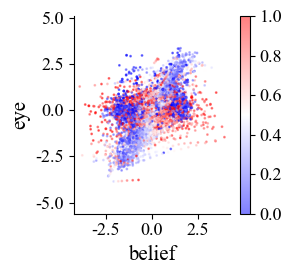

In [304]:
'''
time ratio shows, the x is early on in trials. either strong correlation or no corr. later, corerlation become weak.
'''
for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    timer=np.concatenate(sessdf.time_ratio.to_numpy())
    
    related_taskvar, mask = process([state, belief, eye], returnmask=True)
    [state, belief, eye]=zip(*related_taskvar)
    timer=timer[mask]
    # maskvar=np.array(eye)
    # mask=(maskvar<=-2)|(maskvar>2)
    # print(len(eye))
    # state, belief, eye=[np.array(a)[mask] for a in [state, belief, eye]]
    # print(eye.shape)


    fig, ax = plt.subplots(figsize=(3,3))
    c=ax.scatter(belief,eye, c=timer, cmap='bwr', s=1, alpha=0.5)
    plt.colorbar(c)

    # slope=plot_best_fit(belief,eye, ax)
    # print(slope)
    # r,_=pearsonr(belief,eye)
    # ax.set_title(f'Pearson r: {r:.2f}')

    ax.set_xlabel(f'belief')
    ax.set_ylabel(f'eye')
    ax.axis('equal')

    plt.tight_layout()

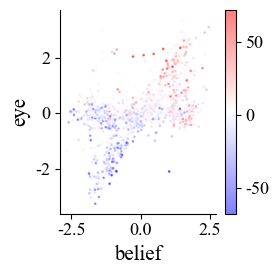

In [321]:
'''
actions at when belief eye differ
'''
for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    timer=np.concatenate(sessdf.time_ratio.to_numpy())
    mv=np.concatenate(sessdf.mv.to_numpy())
    mw=np.concatenate(sessdf.mw.to_numpy())
    
    related_taskvar, mask = process([state, belief, eye], returnmask=True)
    [state, belief, eye]=zip(*related_taskvar)
    timer=timer[mask]
    mv=mv[mask]
    mw=mw[mask]

    colorvar=mw
    maskvar=np.array(timer)
    mask=(maskvar<=0.2)&(maskvar>0)
    belief, eye, colorvar = [np.array(a)[mask] for a in [belief, eye, colorvar]]

    fig, ax = plt.subplots(figsize=(3,3))
    c=ax.scatter(belief,eye, c=colorvar, cmap='bwr', s=1, alpha=0.5)
    plt.colorbar(c)

    # slope=plot_best_fit(belief,eye, ax)
    # print(slope)
    # r,_=pearsonr(belief,eye)
    # ax.set_title(f'Pearson r: {r:.2f}')

    ax.set_xlabel(f'belief')
    ax.set_ylabel(f'eye')
    ax.axis('equal')

    plt.tight_layout()

9637
(706,)
1.4611001307122706


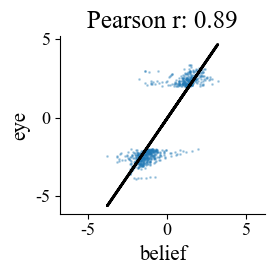

In [285]:
# when belief eye are different (try to seperate the x)
'''idea, there is a x when plot belief-eye scatter. 
can seperate the x by fitting the main bar (smaller err)
small wing has larger error'''

for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    
    related_taskvar = process([state, belief, eye])
    [state, belief, eye]=zip(*related_taskvar)
    
    maskvar=np.array(eye)
    mask=(maskvar<=-2)|(maskvar>2)
    print(len(eye))
    state, belief, eye=[np.array(a)[mask] for a in [state, belief, eye]]
    print(eye.shape)
    # related_taskvar = process([state, belief, eye])

    fig, ax = plt.subplots(figsize=(3,3))
    ax.scatter(belief,eye, s=1, alpha=0.3)

    slope=plot_best_fit(belief,eye, ax)
    print(slope)
    r,_=pearsonr(belief,eye)

    ax.set_xlabel(f'belief')
    ax.set_ylabel(f'eye')
    ax.axis('equal')
    ax.set_title(f'Pearson r: {r:.2f}')

    plt.tight_layout()

# plots

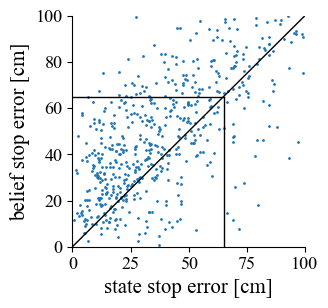

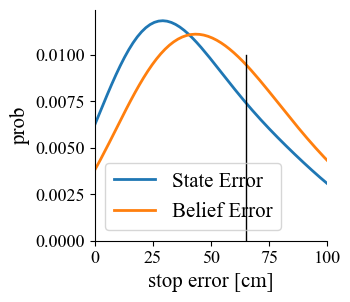

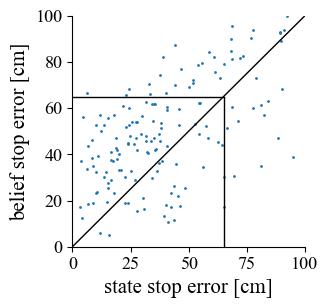

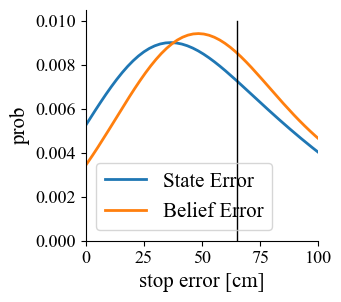

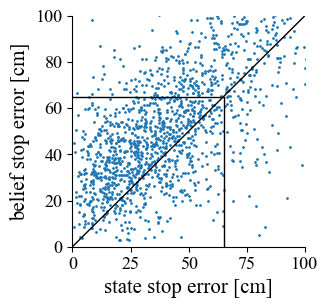

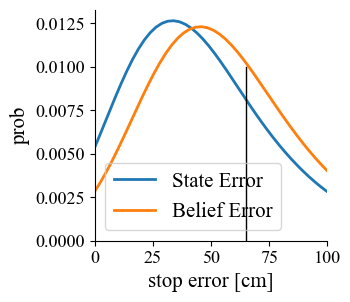

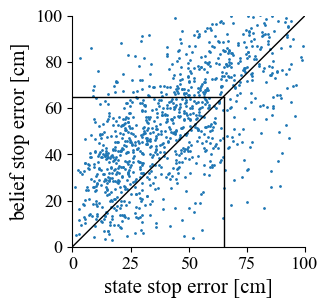

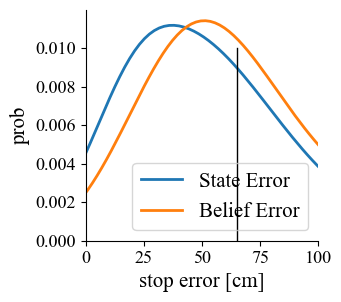

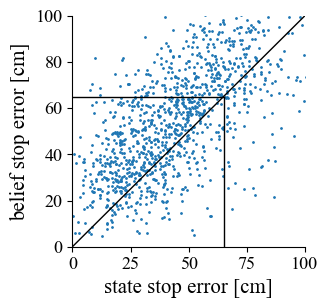

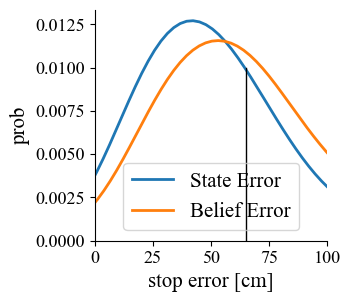

In [114]:
# state vs belief stop error
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())

    fig, ax = plt.subplots(1,1, figsize=(3,3))
    ax.scatter(state_error,belief_error, s=1, alpha=1)
    ax.plot([0,222],[0,222],color='black', linewidth=1)
    ax.plot([0,65],[65,65],color='black', linewidth=1)
    ax.plot([65,65],[65,0],color='black', linewidth=1)
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    ax.set_xlabel('state stop error [cm]')
    ax.set_ylabel('belief stop error [cm]')
    # ax.axis('equal')
    quickspine(ax)
    fig.show()

    fig, ax = plt.subplots(1,1, figsize=(3,3))
    sns.kdeplot(state_error, ax=ax, label='State Error',bw=0.5)
    sns.kdeplot(belief_error, ax=ax, label='Belief Error',bw=0.5)
    ax.plot([65,65],[0.01,0],color='black', linewidth=1)
    ax.set_xlabel('stop error [cm]')
    ax.set_ylabel('prob')
    ax.set_xlim(0,100)
    ax.legend()
    quickspine(ax)
    fig.show()

  

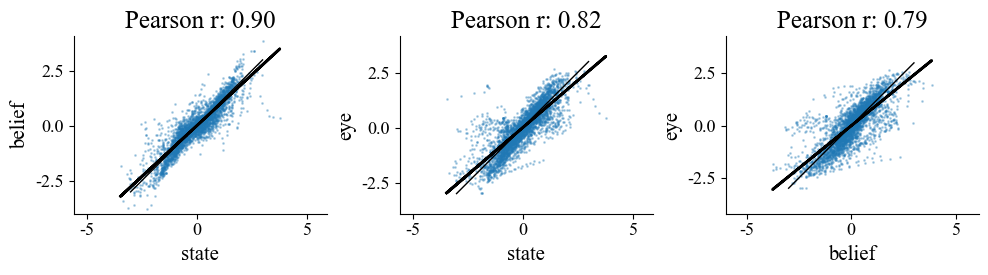

In [243]:
# state, eye, belief corr (masked by time ratio)

for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    
    maskvar=np.concatenate(sessdf.time_ratio.to_numpy())
    mask=(maskvar<=0.6) & (maskvar>0.2)
    [state, belief, eye]=[a[mask] for a in [state, belief, eye]]
    related_taskvar = process([state, belief, eye])
    
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    names=['state','belief','eye']
    k=0
    for i in range(3):
        for j in range(i+1,3):
            axs[k].scatter(related_taskvar[:,i], related_taskvar[:,j], s=1, alpha=0.3)
            axs[k].plot([-3,3],[-3,3],color='black', linewidth=1)
            
            plot_best_fit(related_taskvar[:,i], related_taskvar[:,j], axs[k])
            # quickallspine(ax)
            ax.axis('equal')
            r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])

            axs[k].set_xlabel(f'{names[i]}')
            axs[k].set_ylabel(f'{names[j]}')
            axs[k].axis('equal')
            axs[k].set_title(f'Pearson r: {r:.2f}')
            k+=1
    plt.tight_layout()

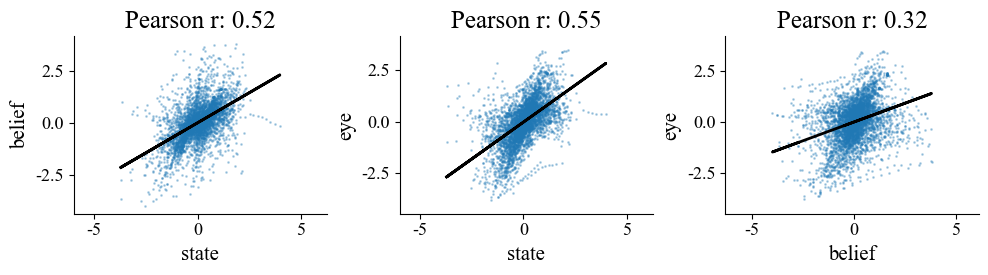

In [212]:
# state, eye, belief corr (masked by time)

for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())
    
    markvar=np.concatenate(sessdf.timer.to_numpy())
    mask=(markvar>7)
    [state, belief, eye]=[a[mask] for a in [state, belief, eye]]

    related_taskvar = process([state, belief, eye])
    
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    names=['state','belief','eye']
    k=0
    for i in range(3):
        for j in range(i+1,3):
            axs[k].scatter(related_taskvar[:,i], related_taskvar[:,j], s=1, alpha=0.3)
            # axs[k].plot([-3,3],[-3,3],color='black', linewidth=1)
            
            plot_best_fit(related_taskvar[:,i], related_taskvar[:,j], axs[k])
            # quickallspine(ax)
            ax.axis('equal')
            r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])

            axs[k].set_xlabel(f'{names[i]}')
            axs[k].set_ylabel(f'{names[j]}')
            axs[k].axis('equal')
            axs[k].set_title(f'Pearson r: {r:.2f}')
            k+=1
    plt.tight_layout()

slope 0.8568825494483189
slope 0.7189490122674834
slope 0.5543037745682343
slope 0.8829408826488124
slope 0.7696565998122302
slope 0.538586762828012
slope 0.757552068518508
slope 0.6649455320550915
slope 0.5640237912848641
slope 0.770336910841795
slope 0.656269019421956
slope 0.5666252100412207
slope 0.859036755195298
slope 0.7087417902362577
slope 0.6300905040839236


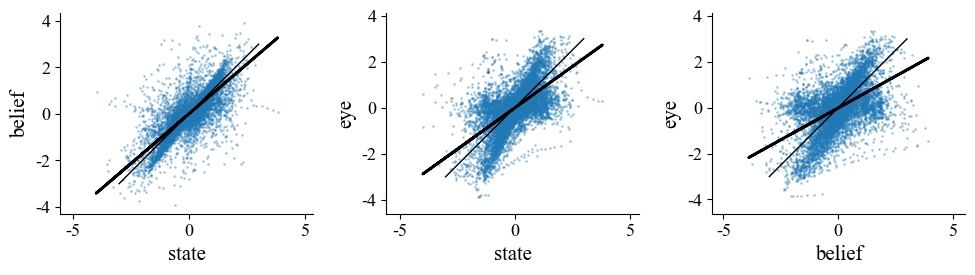

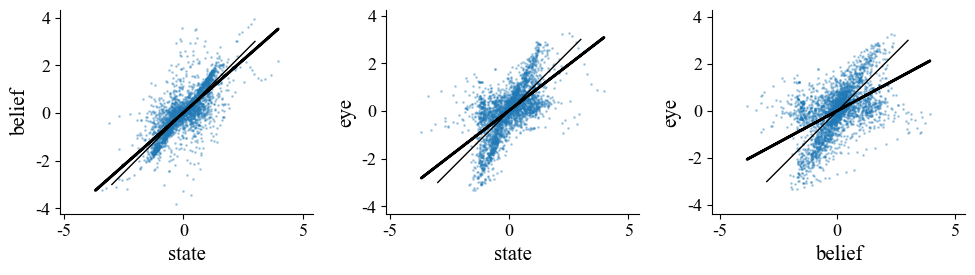

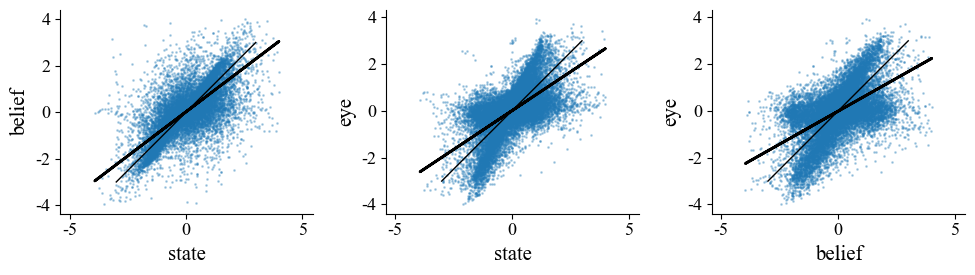

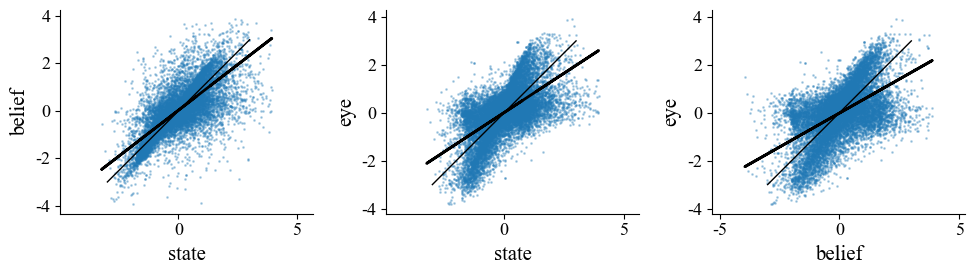

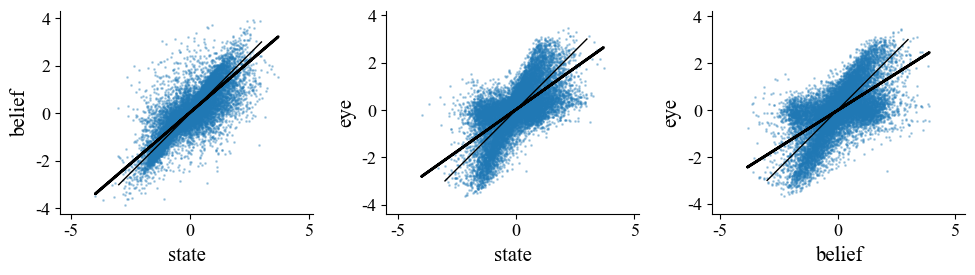

In [215]:
# state, eye, belief corr
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
    belief=np.concatenate(sessdf.ff_hori.to_numpy())
    eye=np.concatenate(sessdf.eye_hori.to_numpy())

    related_taskvar = process([state, belief, eye])
    
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    names=['state','belief','eye']
    k=0
    for i in range(3):
        for j in range(i+1,3):
            axs[k].scatter(related_taskvar[:,i], related_taskvar[:,j], s=1, alpha=0.3)
            axs[k].plot([-3,3],[-3,3],color='black', linewidth=1)
            s=plot_best_fit(related_taskvar[:,i], related_taskvar[:,j], axs[k])
            axs[k].set_xlabel(f'{names[i]}')
            axs[k].set_ylabel(f'{names[j]}')
            axs[k].axis('equal')
            k+=1
    plt.tight_layout()

In [116]:
# # overhead stops subtraction
# state_error=(df.state_error.to_numpy())
# belief_error=(df.belief_error.to_numpy())

# fig, ax = plt.subplots(1,1, figsize=(4,4))
# overheadbase(ax)
# bsdiff=[a-b for a,b in zip(belief_error, state_error)]
# target_location=np.array([(x[0],y[0]) for x,y in zip(df.fx.to_list(), df.fy.to_list())])

# vm=np.max(np.abs(bsdiff))
# cax=ax.scatter(target_location[:,0], target_location[:,1], s=5, c=bsdiff, cmap='bwr', vmin=-vm, vmax=vm)
# cbar = fig.colorbar(cax,shrink=0.6, label='belief reward - state reward')


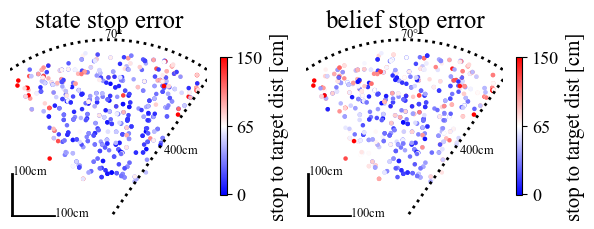

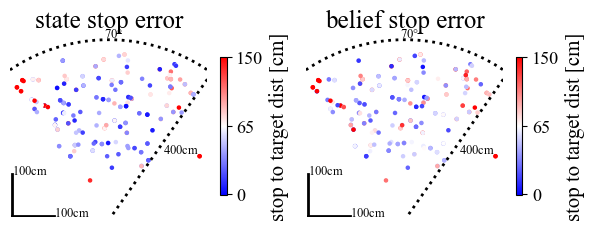

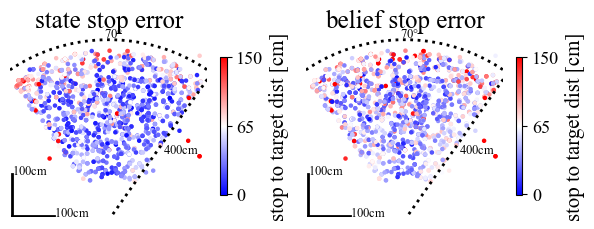

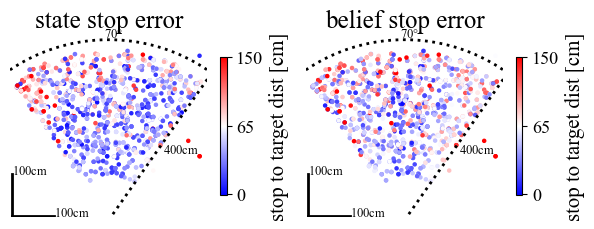

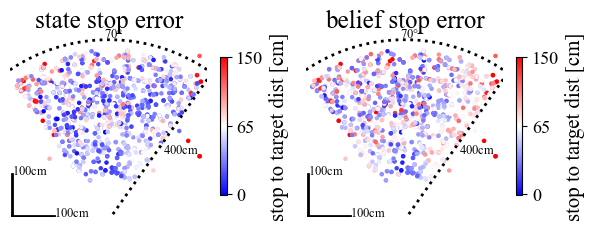

In [117]:
# overhead stops
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())
    
    target_location=np.array([(x[0],y[0]) for x,y in zip(sessdf.fx.to_list(), sessdf.fy.to_list())])
    norm=getcbarnorm(0, 65, 150)

    fig, axs = plt.subplots(1,2, figsize=(7,3))
    ax=axs[0]
    overheadbase(ax)
    cax=ax.scatter(target_location[:,0], target_location[:,1], s=5, c=state_error, cmap='bwr', norm=norm)
    cbar = fig.colorbar(cax,shrink=0.6, label='stop to target dist [cm]')
    cbar.ax.yaxis.set_ticks([1,65,150])
    cbar.ax.yaxis.set_ticklabels([0,65,150])
    ax.set_title('state stop error')

    ax=axs[1]
    overheadbase(ax)
    cax=ax.scatter(target_location[:,0], target_location[:,1], s=5, c=belief_error, cmap='bwr', norm=norm)
    cbar = fig.colorbar(cax,shrink=0.6, label='stop to target dist [cm]')
    cbar.ax.yaxis.set_ticks([1,65,150])
    cbar.ax.yaxis.set_ticklabels([0,65,150])
    ax.set_title('belief stop error')

    plt.show()

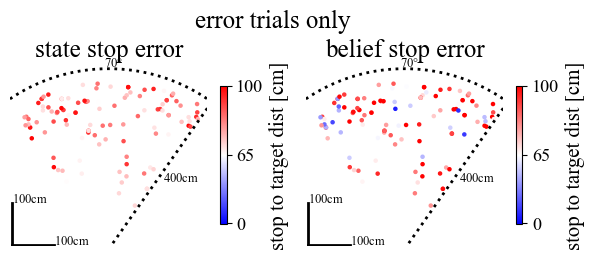

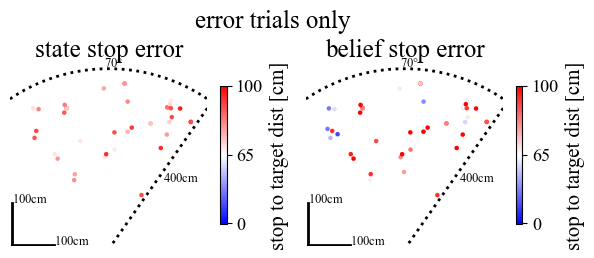

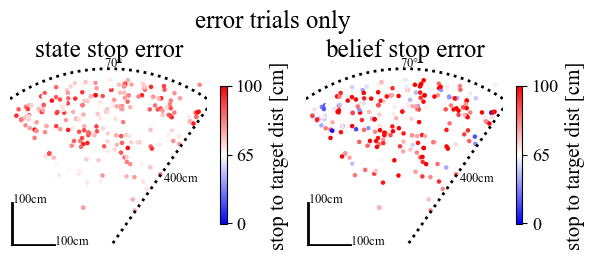

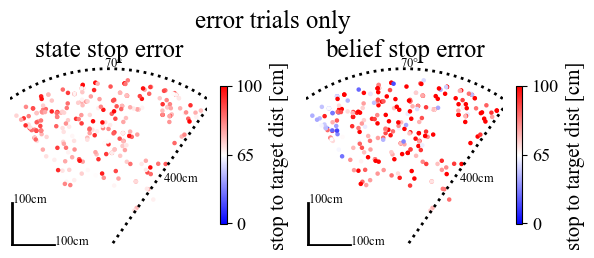

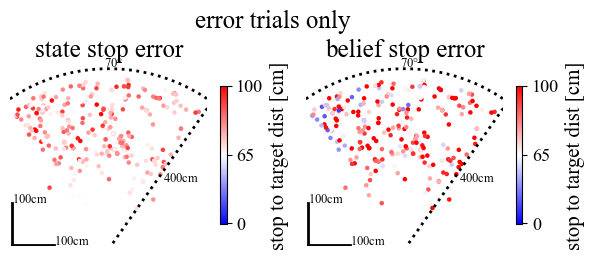

In [118]:
# overhead stops for error trials
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())
    
    target_location=np.array([(x[0],y[0]) for x,y in zip(sessdf.fx.to_list(), sessdf.fy.to_list())])
    norm=getcbarnorm(0, 65, 100)

    fig, axs = plt.subplots(1,2, figsize=(7,3))
    ax=axs[0]
    overheadbase(ax)
    mask=(state_error>65) & (state_error<100)
    cax=ax.scatter(target_location[mask,0], target_location[mask,1], s=5, c=state_error[mask], cmap='bwr', norm=norm)
    cbar = fig.colorbar(cax,shrink=0.6, label='stop to target dist [cm]')
    cbar.ax.yaxis.set_ticks([1,65,100])
    cbar.ax.yaxis.set_ticklabels([0,65,100])
    ax.set_title('state stop error')

    ax=axs[1]
    overheadbase(ax)
    # mask= (belief_error>65) & (belief_error<100)
    cax=ax.scatter(target_location[mask,0], target_location[mask,1], s=5, c=belief_error[mask], cmap='bwr', norm=norm)
    cbar = fig.colorbar(cax,shrink=0.6, label='stop to target dist [cm]')
    cbar.ax.yaxis.set_ticks([1,65,100])
    cbar.ax.yaxis.set_ticklabels([0,65,100])
    ax.set_title('belief stop error')
    fig.suptitle('error trials only')
    plt.show()

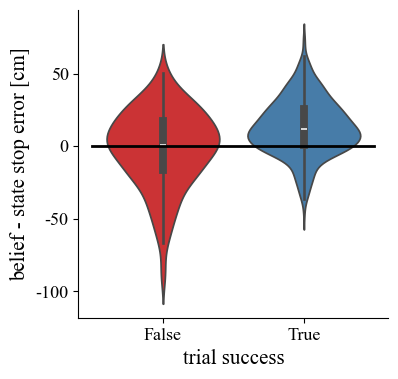

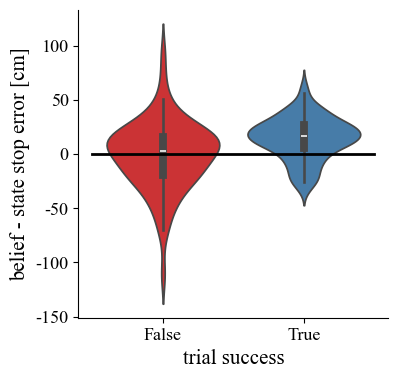

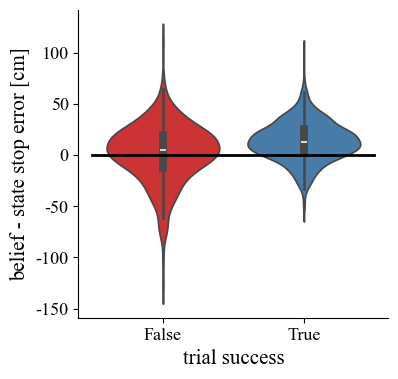

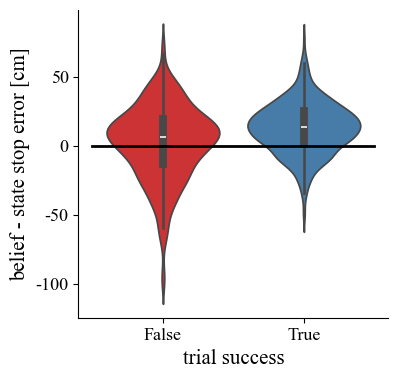

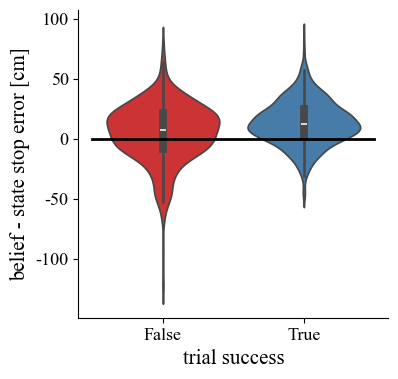


    above zero line, belief stop error > state stop error.
    below zero line, belief stop error < state stop error.
    


In [119]:
# radial err vs belief explaining corr
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())
    
    x,y=belief_error-state_error, state_error
    plt.figure(figsize=(4, 4))
    data = {
        "trial success": y<65,
        "belief explaining power": x,
    }
    sns.violinplot(x="trial success", y="belief explaining power", data=data, palette="Set1")
    plt.xlabel("trial success")
    plt.ylabel("belief - state stop error [cm]")
    plt.plot([-0.5,1.5],[0,0], color='k')
    plt.show()
    
print('''
    above zero line, belief stop error > state stop error.
    below zero line, belief stop error < state stop error.
    ''')

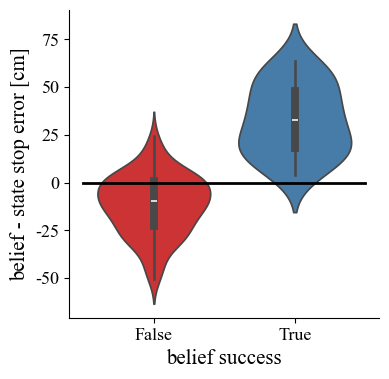

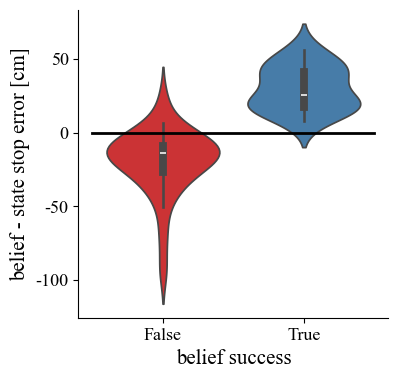

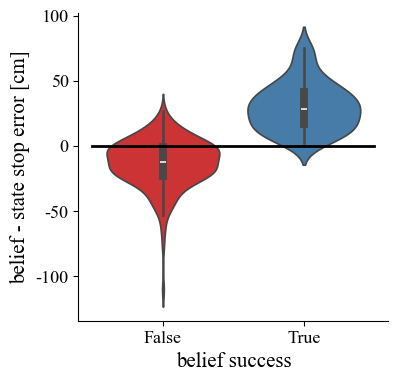

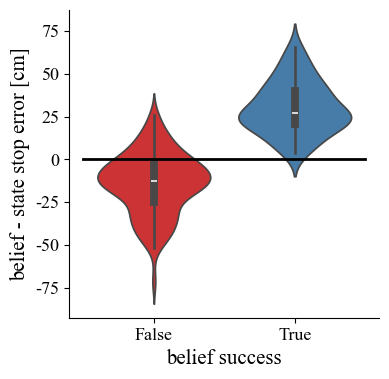

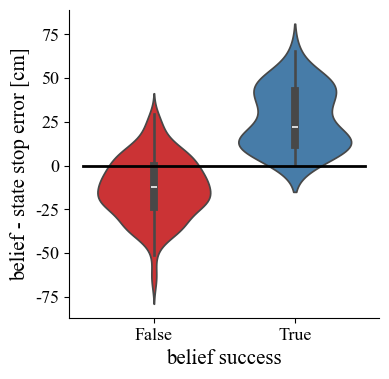


    above zero line, belief stop error > state stop error.
    below zero line, belief stop error < state stop error.
    for the trials mk think he hits, belief error > state error
    for the trials mk think he missed, belief error < state error.
    


In [120]:
# radial err vs belief explaining corr, error trails
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())
    
    mask=(state_error>65) & (state_error<100)
    x,y=state_error[mask]-belief_error[mask], belief_error[mask]
    plt.figure(figsize=(4, 4))
    data = {
        "trial success": y<65,
        "belief explaining power": x,
    }
    sns.violinplot(x="trial success", y="belief explaining power", data=data, palette="Set1")
    plt.xlabel("belief success")
    plt.ylabel("belief - state stop error [cm]")
    plt.plot([-0.5,1.5],[0,0], color='k')
    plt.show()
print('''
    above zero line, belief stop error > state stop error.
    below zero line, belief stop error < state stop error.
    for the trials mk think he hits, belief error > state error
    for the trials mk think he missed, belief error < state error.
    ''')

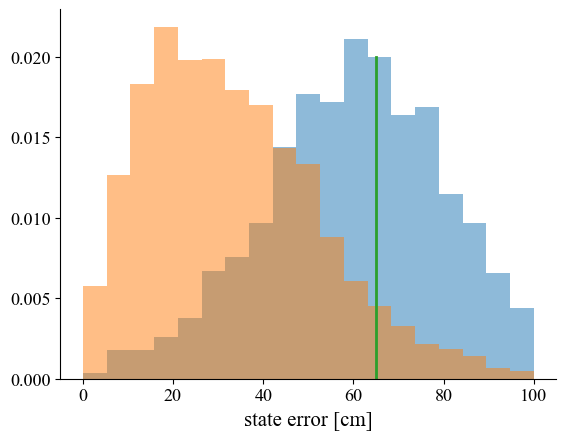

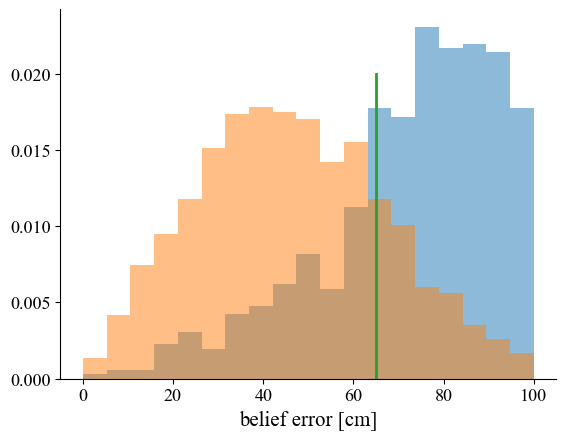

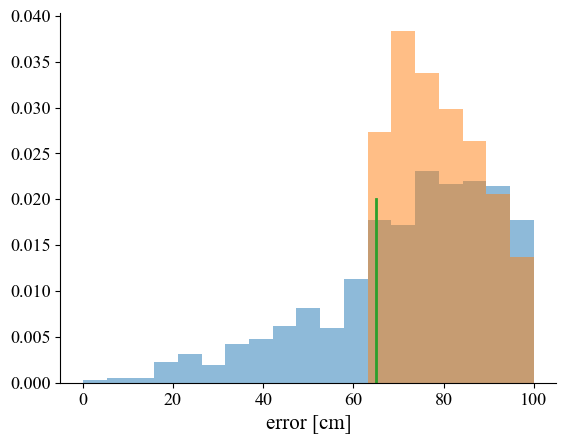

In [121]:
state_error=(df.state_error.to_numpy())
belief_error=(df.belief_error.to_numpy())

statefail=(state_error>65) & (state_error<100)
statehit=(state_error<=65) 
belieffail=(belief_error>65) & (belief_error<100)
beliefhit=(belief_error<=65) 

# plt.hist(state_error[statefail], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
# plt.hist(state_error[statehit], bins=np.linspace(0,100,20), alpha=0.5, density=True) 

plt.hist(state_error[belieffail], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.hist(state_error[beliefhit], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.plot([65,65],[0,0.02])
plt.xlabel('state error [cm]')
plt.show()

plt.hist(belief_error[statefail], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.hist(belief_error[statehit], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.xlabel('belief error [cm]')
plt.plot([65,65],[0,0.02])
plt.show()

plt.hist(belief_error[statefail], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.hist(state_error[statefail], bins=np.linspace(0,100,20), alpha=0.5, density=True) 
plt.xlabel('error [cm]')
plt.plot([65,65],[0,0.02])

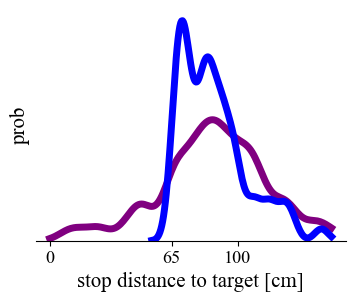

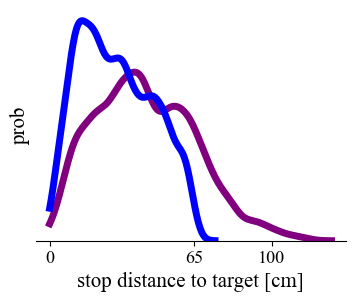

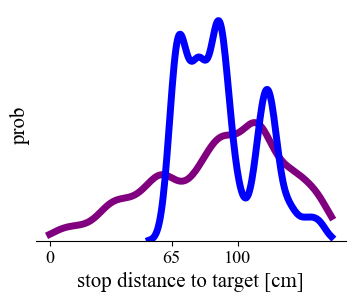

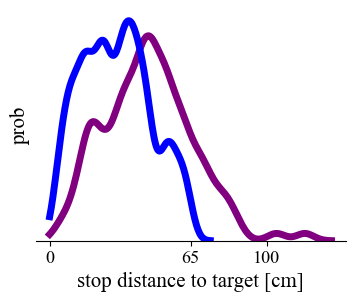

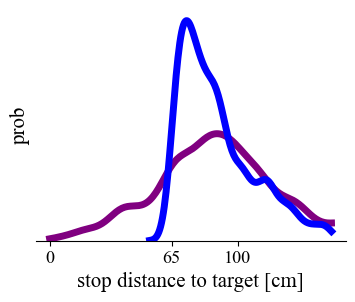

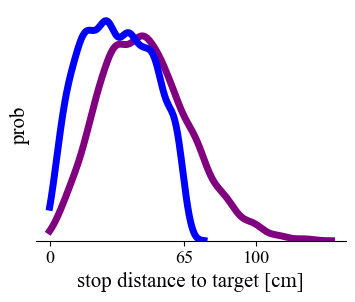

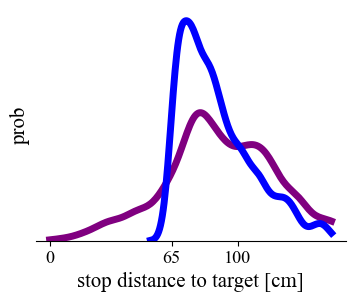

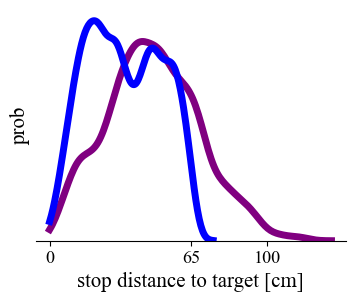

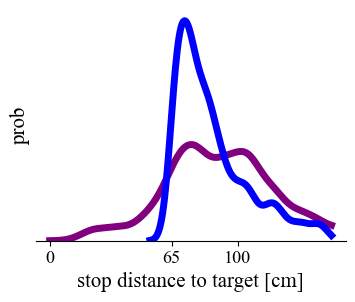

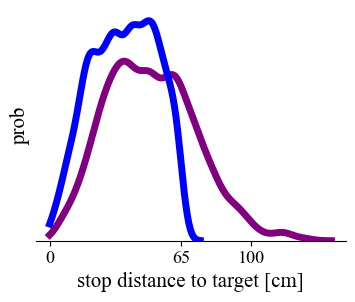

In [122]:
# histogram of distribution
for session in sorted(df.session.unique()):
    sessdf=df[df.session==session]

    state_error=(sessdf.state_error.to_numpy())
    belief_error=(sessdf.belief_error.to_numpy())

    statefail=(state_error>65) & (state_error<150)
    statehit=(state_error<=65) 
    belieffail=(belief_error>65) & (belief_error<150)
    beliefhit=(belief_error<=65) 

    fig, ax = plt.subplots(figsize=(4,3))
    # ax.hist(belief_error[statefail], bins=np.linspace(0,150,30), alpha=0.5, density=True) 
    # ax.hist(state_error[statefail], bins=np.linspace(0,150,30), alpha=0.5, density=True) 
    sns.kdeplot(belief_error[statefail],bw=0.2, clip=(0,150), linewidth=5, color=belief_color)
    sns.kdeplot(state_error[statefail],bw=0.2, clip=(0,150), linewidth=5, color=state_color)
    plt.xlabel('stop distance to target [cm]')
    plt.xticks([0,65,100])
    ax.yaxis.set_ticks([])
    ax.spines['left'].set_visible(False)
    ax.set_ylabel('prob')
    # plt.xlim(0,100)
    plt.show()

    fig, ax = plt.subplots(figsize=(4,3))
    sns.kdeplot(belief_error[statehit],bw=0.2, clip=(0,150), linewidth=5, color=belief_color)
    sns.kdeplot(state_error[statehit],bw=0.2, clip=(0,150), linewidth=5, color=state_color)
    plt.xlabel('stop distance to target [cm]')
    plt.xticks([0,65,100])
    ax.yaxis.set_ticks([])
    ax.spines['left'].set_visible(False)
    ax.set_ylabel('prob')
    # plt.xlim(0,100)
    plt.show()



In [123]:
# table (todo, roc)
state_error=(df.state_error.to_numpy())
belief_error=(df.belief_error.to_numpy())

statefail=(state_error>65) & (state_error<100)
statehit=(state_error<=65) 
belieffail=(belief_error>65) & (belief_error<100)
beliefhit=(belief_error<=65) 
statefail,statehit, belieffail, beliefhit=np.sum(statefail),np.sum(statehit),np.sum(belieffail),np.sum(beliefhit)

print('fail, hit\n state',statefail,statehit,'\n belief', belieffail, beliefhit)

fail, hit
 state 916 3537 
 belief 1217 3028


In [124]:
# trialidx=np.random.choice(sessdf.trial.unique())
# eye_hori = sessdf[sessdf.trial == trialidx].eye_hori.to_list()[0]
# eye_vert = sessdf[sessdf.trial == trialidx].eye_vert.to_list()[0]
# ff_hori = sessdf[sessdf.trial == trialidx].ff_hori.to_list()[0]
# ff_vert = sessdf[sessdf.trial == trialidx].ff_vert.to_list()[0]
# belief_ff_hori = sessdf[sessdf.trial == trialidx].belief_ff_hori.to_list()[0]
# belief_ff_vert = sessdf[sessdf.trial == trialidx].belief_ff_vert.to_list()[0]

# # Create the plot
# fig, ax = plt.subplots()
# # Plot the gradient lines with custom colormaps
# plot_gradient_line(ax, eye_hori, eye_vert, cmap_eye)
# plot_gradient_line(ax, ff_hori, ff_vert, cmap_state)
# plot_gradient_line(ax, belief_ff_hori, belief_ff_vert, cmap_belief)
# plt.title(f'trial: {trialidx}')
# # quickallspine(ax)
# plt.show()

956


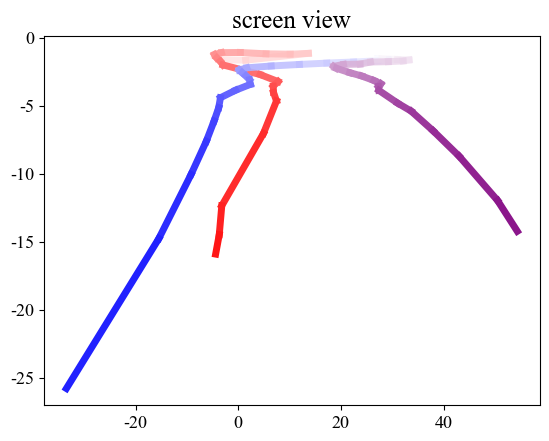

886


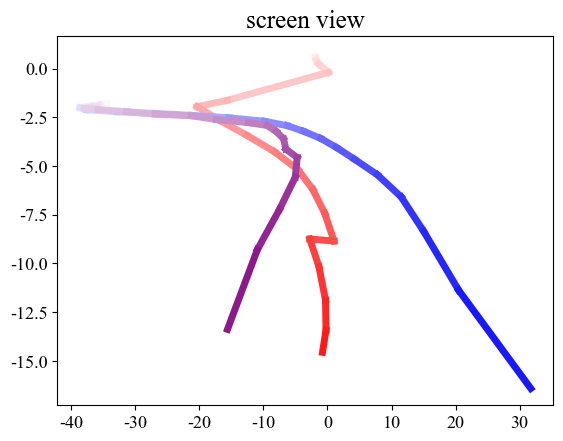

687


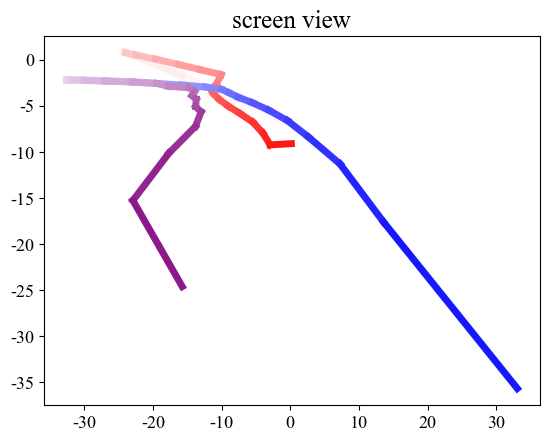

409


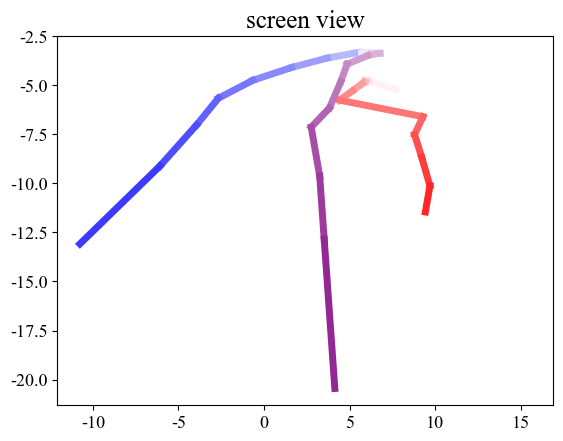

266


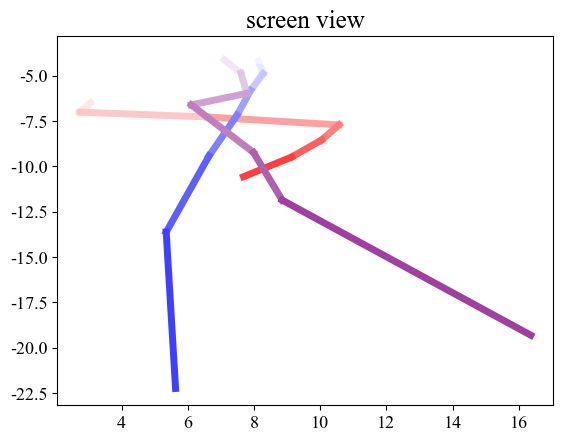

In [139]:
# screen view example trial

cmap_eye = mcolors.LinearSegmentedColormap.from_list('eye_cmap', ['white', eye_color])
cmap_state = mcolors.LinearSegmentedColormap.from_list('state_cmap', ['white', state_color])
cmap_belief = mcolors.LinearSegmentedColormap.from_list('belief_cmap', ['white', belief_color])

def plot_gradient_line(ax, x, y, cmap):
    norm = plt.Normalize(0, len(x))
    for i in range(len(x) - 1):
        ax.plot(x[i:i+2], y[i:i+2], color=cmap(norm(i)), alpha= np.clip(i /len(x)+0.6, 0,1), linewidth=5)
# trialidx=np.random.choice(sessdf.trial.unique())
for trialidx in [956,886,687,409,266]:
    print(trialidx)
    eye_hori = sessdf[sessdf.trial == trialidx].eye_hori.to_list()[0]
    eye_vert = sessdf[sessdf.trial == trialidx].eye_vert.to_list()[0]
    ff_hori = sessdf[sessdf.trial == trialidx].ff_hori.to_list()[0]
    ff_vert = sessdf[sessdf.trial == trialidx].ff_vert.to_list()[0]
    belief_ff_hori = sessdf[sessdf.trial == trialidx].belief_ff_hori.to_list()[0]
    belief_ff_vert = sessdf[sessdf.trial == trialidx].belief_ff_vert.to_list()[0]

    # Create the plot
    fig, ax = plt.subplots()
    # Plot the gradient lines with custom colormaps
    plot_gradient_line(ax, eye_hori, eye_vert, cmap_eye)
    plot_gradient_line(ax, ff_hori, ff_vert, cmap_state)
    plot_gradient_line(ax, belief_ff_hori, belief_ff_vert, cmap_belief)
    # plt.title(f'trial: {trialidx}')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    # ax.xaxis.set_ticks([])
    # ax.yaxis.set_ticks([])
    ax.set_title('screen view')
    plt.show()


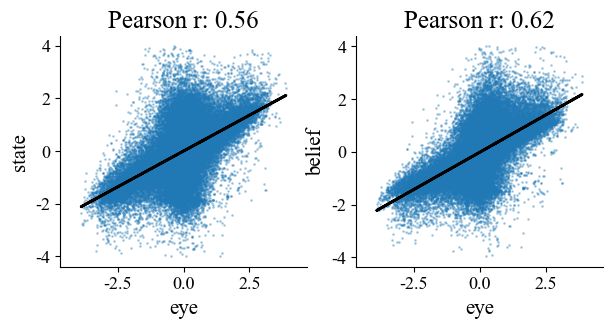

In [126]:
# correlation scatter
def plot_best_fit(x,y,ax):
    slope, intercept = np.polyfit(x,y, 1)
    best_fit_line = slope * x + intercept
    ax.plot(x, best_fit_line, color='black')

sessdf=df

# state=np.concatenate(sessdf.heading.to_numpy())
# belief=np.concatenate(sessdf.belief_heading.to_numpy())
state=np.concatenate(sessdf.ff_hori.to_numpy())
belief=np.concatenate(sessdf.belief_ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())

mask=state!=0
state,belief,eye=state[mask],belief[mask],eye[mask]
related_taskvar = process([state, belief, eye])
names=['state', 'belief']
fig, axs = plt.subplots(1,2, figsize=(7,3))
for i in range(2):
    axs[i].scatter(related_taskvar[:,2], related_taskvar[:,i], s=1, alpha=0.3)
    # axs[i].plot([-3,3],[-3,3],color='black', linewidth=1)

    plot_best_fit(related_taskvar[:,2], related_taskvar[:,i],axs[i])

    axs[i].set_xlabel(f'eye')
    axs[i].set_ylabel(f'{names[i]}')
    axs[i].axis('equal')
    r,_=pearsonr(related_taskvar[:,i], related_taskvar[:,j])
    axs[i].set_title(f'Pearson r: {r:.2f}')
    k+=1

